In [1]:
# configure plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable #for subplot colorbars
from matplotlib.pyplot import cm

%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 6 / 1.6), 'font.size': 8, \
                            'figure.facecolor': (1, 1, 1, 0),'font.sans-serif':'Latin Modern Math'}

from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

%matplotlib inline

#dark plotting
plt.style.use('dark_background')

In [2]:
import numpy as np

In [3]:
def make_time(sample_frequency,sample_time):
    
    sample_number = int(sample_frequency * sample_time) #number of samples is the produce ot sample frequency and total measurement time
    
    taxis = np.linspace(0,1,sample_frequency) #make a vector from 0 to 1s in increments of sample number in units of s
    dt = taxis[1]-taxis[0] # sample spacing
    # dt is also simply 1/sample rate
    taxis = np.arange(0,sample_time,dt)
    
    return taxis

In [4]:
FFT_1600_taxis =  make_time(int(2.5e3),1.6)

# Reading vibrometer outputs

In [5]:
import os
import glob
import natsort
import numpy as np

In [6]:
def mirror_complex_fft(complex_fft):
    
    fft_vector = (complex_fft) #/ len(faxis)  #making a fft vector of complex -- should some scaling go in here to correct for polytec yscale?
    fft_vector_copy = fft_vector.copy() #making a copy of the fft vector
    fft_mirrored = fft_vector_copy[::-1] #flipping such that vectors starta with most negative frequencies
    fft_joined = np.append(fft_vector,fft_mirrored) #appending both vectors

    return fft_joined

In [7]:
def load_vibrometer_scan(path,extension):
    "this function takes a vibrometer output text file and creates a"
    "complex-valued array of the fft. also mirrors these data for proper formatting to ifft functions"
    
    #loading files names
    os.chdir(path)
    file_names = []
    
    for name in glob.glob(extension):
        file_names.append(name)
        
    file_names = natsort.natsorted(file_names, reverse=False)

###############################################################################
    complex_fft = [[] for _ in range(len(file_names))]
    fbins = [[] for _ in range(len(file_names))]
    complex_fft_mirror = [[] for _ in range(len(file_names))]

    for scan_point in range(len(file_names)):

        #loading a .txt file, only the numerical data and not the header info
        vibrometer_complex_temp = np.loadtxt(file_names[scan_point],skiprows = 7) 
        
        #swapping axes so that data are ordered by columns
        vibrometer_complex_temp = np.swapaxes(vibrometer_complex_temp,0,1) 
        
        #making a single complex-valued vector
        complex_fft[scan_point] = np.stack((vibrometer_complex_temp[1], vibrometer_complex_temp[2]), axis=-1).view(complex).squeeze(-1)  

        #mirroring the complex-valued fft for later use in ifft
        complex_fft_mirror[scan_point] = mirror_complex_fft(complex_fft[scan_point])

        #reading frequency bins and making negative for mirrored fft
        fbins_positive = vibrometer_complex_temp[0]
        fbins_negative = -fbins_positive[::-1]
    
        fbins[scan_point] = np.concatenate((fbins_positive,fbins_negative))
###############################################################################    
    #i suppose i could retrieve the complex, un-mirrored fft -- but for now the ifft is important so i will take only the mirrored
    return np.asarray(fbins),np.asarray(complex_fft_mirror)

# Loading data

## High Slope

In [8]:
path ='/Volumes/Extreme Pro/Projects/Vibrometer/Data/2024_04/2024_04_13_20kHz_1600fft/'
extension = '2024_04_13_20kHz_1600fft*.txt'

high_slope_fbins,high_slope_fft = load_vibrometer_scan(path,extension)

In [9]:
high_slope_fbins.shape

(34543, 3200)

## Low Slope

In [10]:
path ='/Volumes/Extreme Pro/Projects/Vibrometer/Data/2024_04/2024_04_17/2024_04_17'
extension = '2024_04_17_*.txt'

low_slope_fbins,low_slope_fft = load_vibrometer_scan(path,extension)

## test

In [23]:
fft = high_slope_fft[900]
fft_conj = np.conj(fft)

autocorrelation = np.fft.ifft( fft * fft_conj)
autocorrelation = autocorrelation / np.max(autocorrelation)
n_autocorr = len(autocorrelation)

#dom
dom = np.fft.fft(autocorrelation)
n_dom = len(dom)
timestep = 1/40e3
dom_bins = np.fft.fftfreq(n_dom, d=timestep)

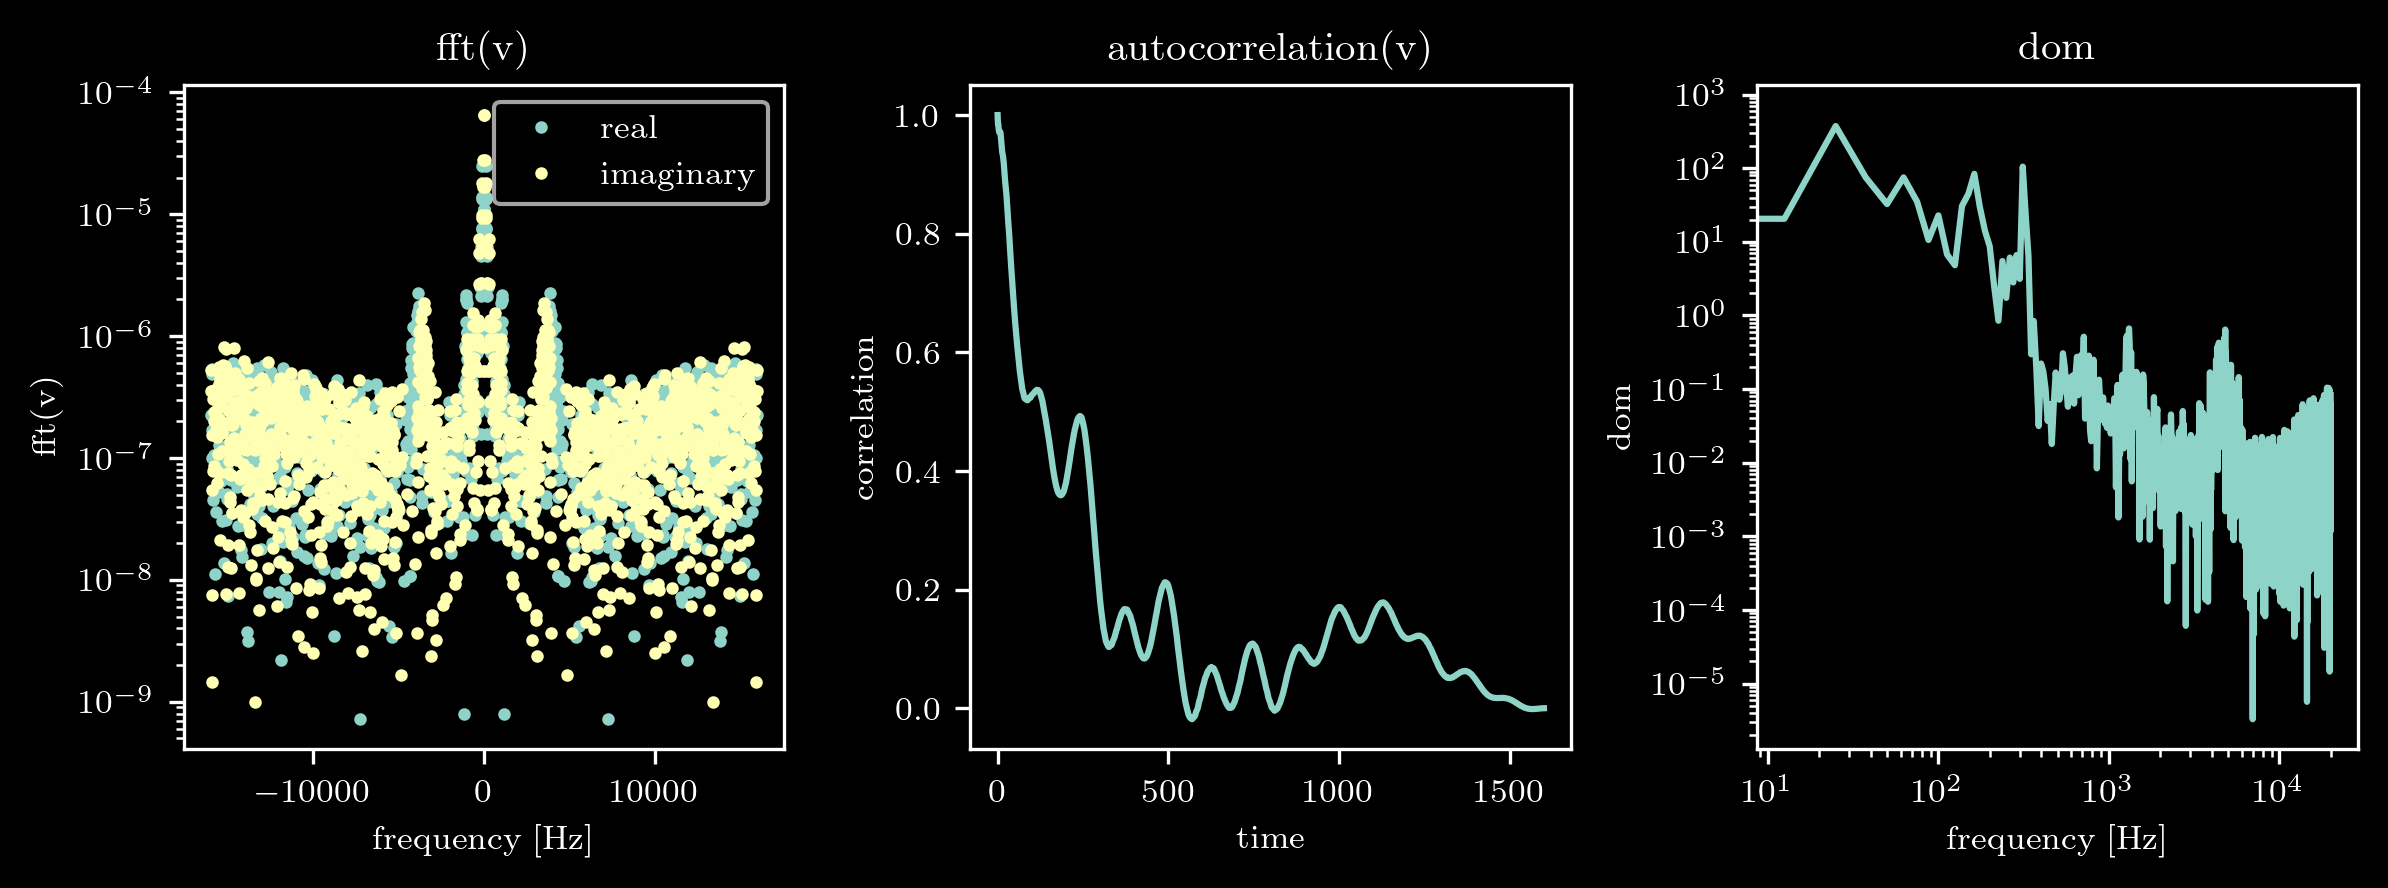

In [24]:
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.plot(high_slope_fbins[400],fft.real,'o',markersize = 2,label = 'real')
ax1.plot(high_slope_fbins[400],fft.imag,'o',markersize = 2,label = 'imaginary')

ax1.set_yscale('log')
ax1.set_title('fft(v)')
ax1.set_xlabel('frequency [Hz]')
ax1.set_ylabel('fft(v)')
ax1.legend()

ax2.set_title('autocorrelation(v)')
ax2.plot(autocorrelation[:n_autocorr//2].real)
ax2.set_xlabel('time')
ax2.set_ylabel('correlation')

ax3.set_title('dom')
ax3.plot(dom_bins[:n_dom//2],dom.real[:n_dom//2])
ax3.set_xlabel('frequency [Hz]')
ax3.set_ylabel('dom')
ax3.set_xscale('log')
ax3.set_yscale('log')

fig.tight_layout()

# plt.savefig("/Volumes/Extreme Pro/Projects/Vibrometer/Figures/output_example" + ".jpg",format="JPG",bbox_inches='tight')

## dom Loop

## high slope

In [13]:
dom = [[] for _ in range(high_slope_fft.shape[0])]

for scan_point in range(len(high_slope_fft)):
    
    fft = high_slope_fft[scan_point]
    fft_conj = np.conj(fft)
    
    autocorrelation = np.fft.ifft( fft * fft_conj)
    autocorrelation = autocorrelation / np.max(autocorrelation)
    n_autocorr = len(autocorrelation)
    
    #dom
    dom[scan_point] = np.fft.fft(autocorrelation)

dom_high_slope = np.asarray(dom)
dom_high_slope_mean = np.mean((dom_high_slope),axis = 0)

## 2d histogram

In [18]:
np.max(high_slope_fbins[0])

16000.0

Text(0.5, 1.0, 'count')

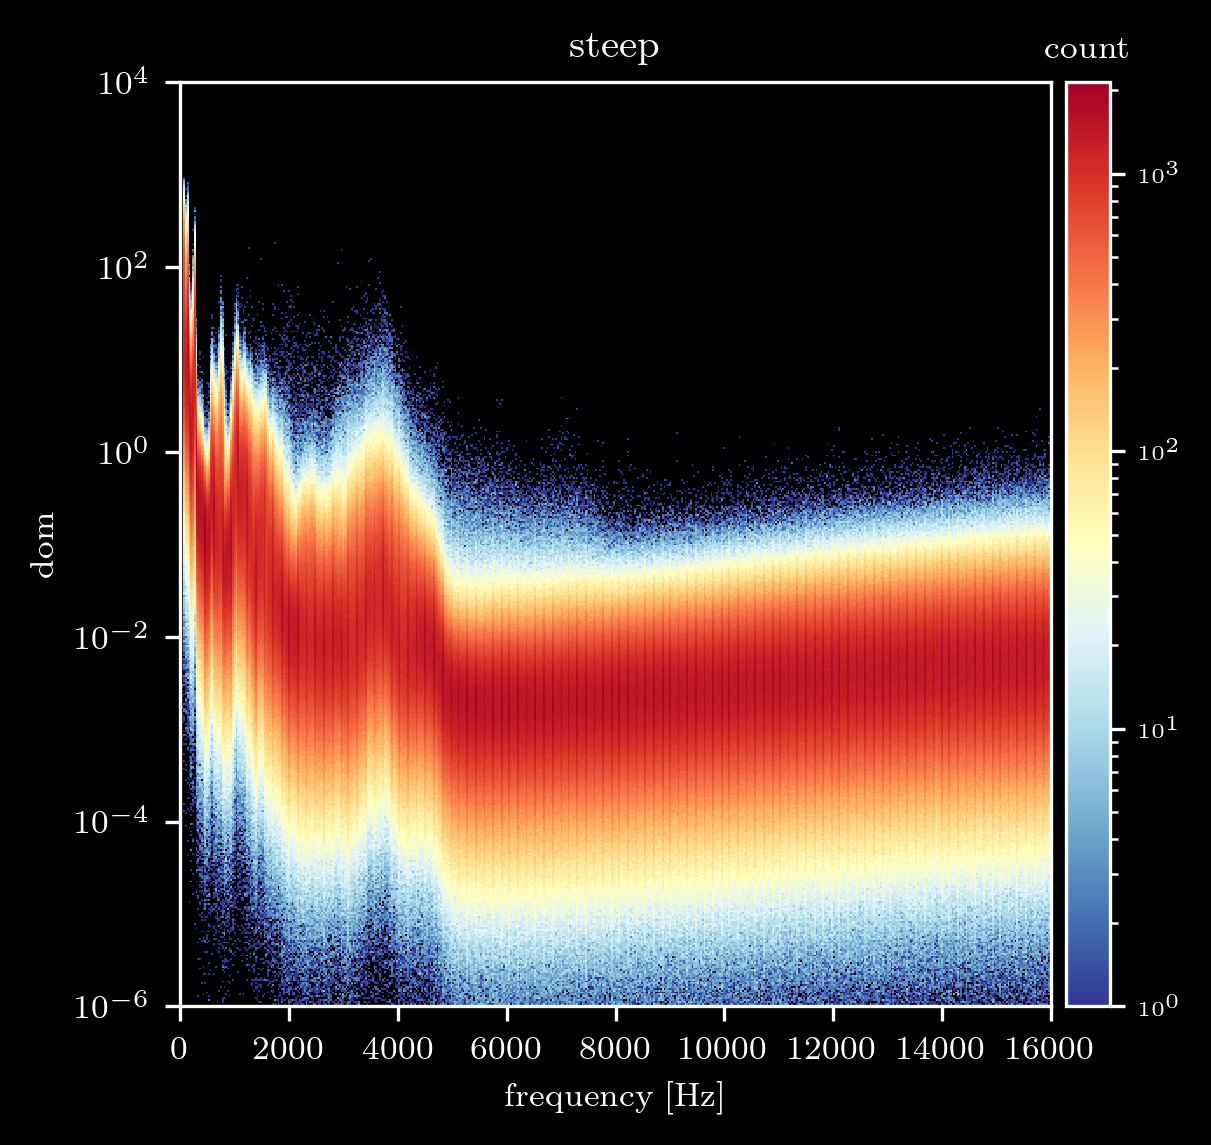

In [25]:
fbins = high_slope_fbins[0][:len(dom_high_slope_mean)//2]
fbins = fbins/fbins**2

cmap = 'RdYlBu_r'
# cmap = 'rainbow'


import matplotlib as mpl

xbins = np.linspace(0, 16000, 500)
ybins = np.logspace(np.log10(0.000001), np.log10(10000.0), 500)

# xbins = np.logspace(np.log10(1.0), np.log10(1000.0), 50)
# ybins = np.logspace(np.log10(1), np.log10(10000.0), 100)

fig = plt.figure(figsize=(4, 4))
ax1 = plt.subplot(111)


hist1 = ax1.hist2d(high_slope_fbins.ravel(),
           dom_high_slope.ravel().real,
            norm = mpl.colors.LogNorm(),
           bins = (xbins,ybins),
                  cmap = cmap);


ax1.plot(fbins,dom_high_slope_mean[:len(dom_high_slope_mean)//2].real,'k',label = 'mean')

# ax1.legend()
# ax1.set_xscale('log');
ax1.set_yscale('log');

ax1.set_title('steep')
ax1.set_ylabel('dom')
ax1.set_xlabel('frequency [Hz]')
                 
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(hist1[3],cax=cax1,orientation='vertical')
cax1.tick_params(labelsize=5)
cax1.set_title(r'count', fontsize=8)


# plt.savefig("/Volumes/Extreme Pro/Projects/Vibrometer/Figures/dom_steep" + ".jpg",format="JPG",bbox_inches='tight')

## low slope

In [20]:
dom = [[] for _ in range(low_slope_fft.shape[0])]

for scan_point in range(len(low_slope_fft)):
    
    fft = low_slope_fft[scan_point]
    fft_conj = np.conj(fft)
    
    autocorrelation = np.fft.ifft( fft * fft_conj)
    autocorrelation = autocorrelation / np.max(autocorrelation)
    n_autocorr = len(autocorrelation)
    
    #dom
    dom[scan_point] = np.fft.fft(autocorrelation)

dom_low_slope = np.asarray(dom)
dom_low_slope_mean = np.mean((dom_low_slope),axis = 0)

Text(0.5, 1.0, 'count')

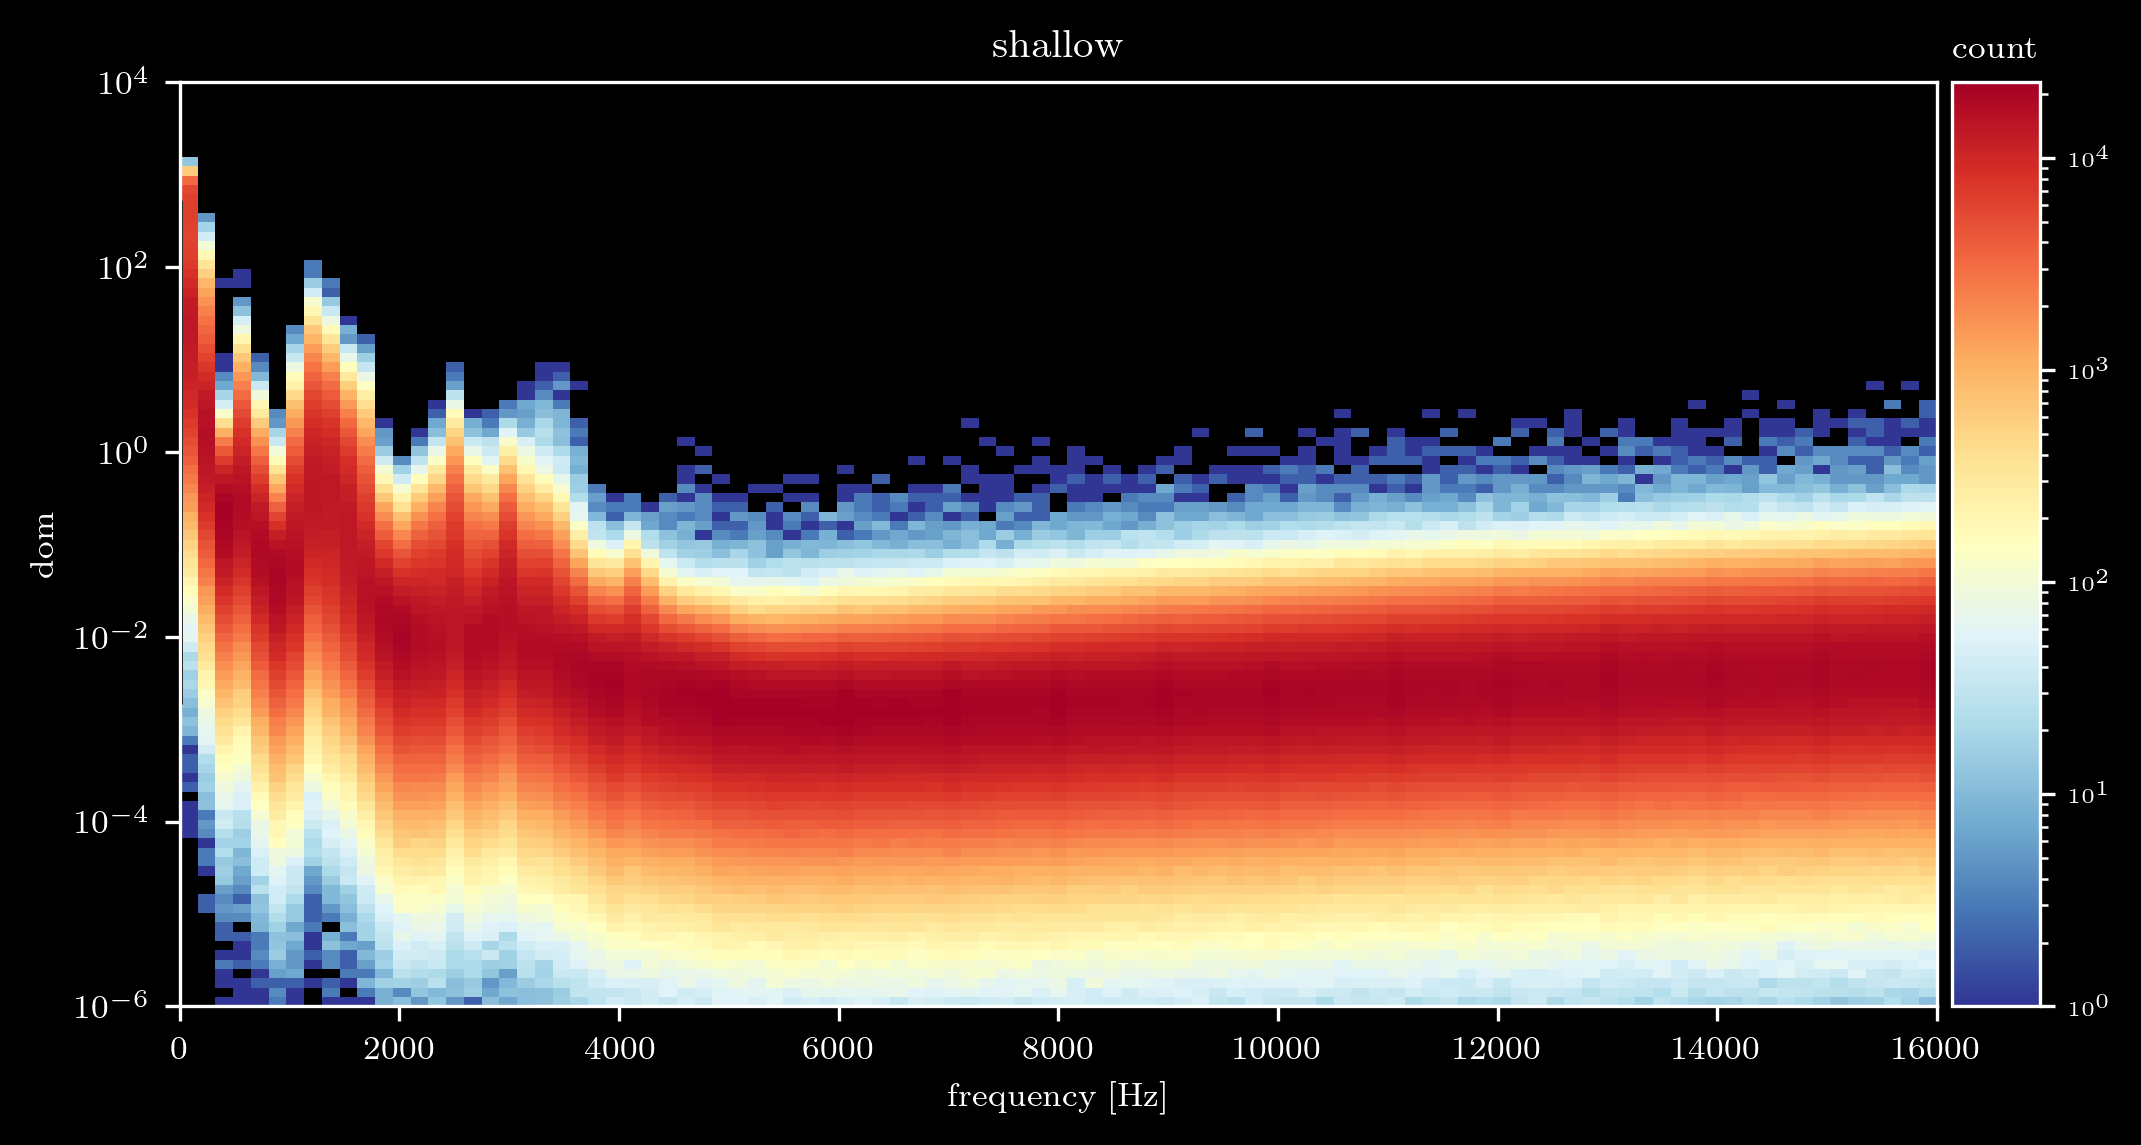

In [21]:
import matplotlib as mpl

xbins = np.linspace(0, 16000, 100)
ybins = np.logspace(np.log10(0.000001), np.log10(10000.0), 100)

# xbins = np.logspace(np.log10(1.0), np.log10(1000.0), 50)
# ybins = np.logspace(np.log10(1), np.log10(10000.0), 100)

fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(111)


hist1 = ax1.hist2d(low_slope_fbins.ravel(),
           dom_low_slope.ravel().real,
            norm = mpl.colors.LogNorm(),
           bins = (xbins,ybins),
                  cmap = cmap);

ax1.plot(fbins,dom_low_slope_mean[:len(dom_low_slope_mean)//2].real,'k',label = 'mean')

# ax1.legend()
# ax1.set_xscale('log');
ax1.set_yscale('log');

ax1.set_title('shallow')
ax1.set_ylabel('dom')
ax1.set_xlabel('frequency [Hz]')
                 
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(hist1[3],cax=cax1,orientation='vertical')
cax1.tick_params(labelsize=5)
cax1.set_title(r'count', fontsize=8)

# plt.savefig("/Volumes/Extreme Pro/Projects/Vibrometer/Figures/dom_shallow" + ".jpg",format="JPG",bbox_inches='tight')

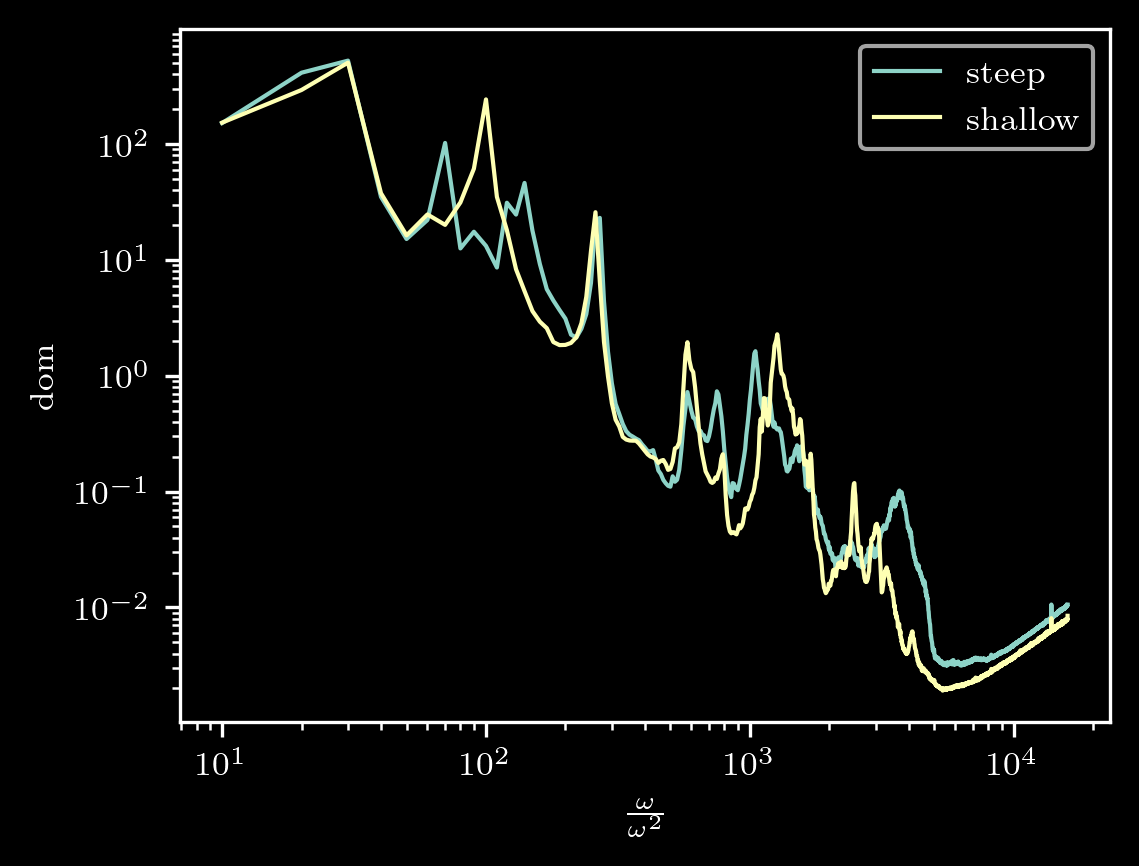

In [26]:
fbins = high_slope_fbins[400] 
fbins = fbins[:len(fbins)//2]
# fbins = fbins / fbins**2

fig = plt.figure(figsize=(4, 3))
ax1 = plt.subplot(111)

ax1.plot(fbins,dom_high_slope_mean[:len(dom_high_slope_mean)//2],label = 'steep',linewidth = 1)
ax1.plot(fbins,dom_low_slope_mean[:len(dom_low_slope_mean)//2],label = 'shallow',linewidth = 1)

# ax1.set_title('shallow')
ax1.set_ylabel('dom')
ax1.set_xlabel(r'$\frac{\omega}{\omega ^ {2}}$')
ax1.set_xscale("log")
ax1.set_yscale("log")
# ax1.set_ylim([1e0,1e5])
ax1.legend()

# IFFT

In [ ]:
taxis = FFT_100_taxis

ifft = np.fft.ifft(BarePiezo_100HzSine_10V[1],n = len(taxis),norm = "forward")#pay attention to normalization methods -- they tune the yscale

In [ ]:
from scipy import integrate

test = integrate.simpson(abs(ifft.real))

In [ ]:
fig = plt.figure(figsize=(6, 3))
ax1 = plt.subplot(111)

ax1.plot(FFT_100_taxis,ifft.real)
ax1.plot(FFT_100_taxis,ifft.imag)

# Velocity autocorrelation from fft

Now for something straighforward: going for a DOM quantity while bypassing the velocity signal in the time-domain.

I should be able to accomplish this by


autocorrelation = ifft( fft * it's complex conjugate)


note:
* v(t) = original data = real
* f(omega) = fft(v(t)) = complex (this is what the vibrometer gives us)
* abs(f(omega)) = real but probably stored as complex (imaginary part should be zero to machine-precision)

In [ ]:
a = abs(fft)[:len(fft)//2]
b = dom.real[:n_dom//2]

a = a/np.max(a)
b = b/np.max(b)

fig = plt.figure(figsize=(6, 4))
ax1 = plt.subplot(111)

ax1.plot(a)
ax1.plot(b)

ax1.set_xscale('log')
ax1.set_yscale('log')